In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [13]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    #     a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
    #                                     action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, labels=next_states_labels)
    eloss = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1))
    #     eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    #     eloss += -tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # maximize loss
    #     aloss2_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    #     aloss2 = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # minimize loss
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    eQs_logits = tf.reshape(eQs, shape=[-1])
    #     aQs_logits = tf.reshape(aQs, shape=[-1])
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
                                                                    labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    eloss += tf.reduce_mean(tf.square(eQs_logits - (gamma * aQs2_logits))) # real
    eloss += tf.reduce_mean(aQs2_logits) # min
    aloss2 += -tf.reduce_mean(aQs2_logits) # max
    return actions_logits, aloss, eloss, aloss2

In [14]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [15]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2, = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [16]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [18]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [19]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [20]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [21]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            #rewards_in = sess.run(model.rewards_in, feed_dict)
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], feed_dict)
            #print('rewards_in.mean():', rewards_in.mean())
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:14.0000 R:14.0000 rate:0.0280 aloss:0.6957 eloss:4.6800 aloss2:0.6700 exploreP:0.9986
Episode:1 meanR:25.0000 R:36.0000 rate:0.0720 aloss:0.6902 eloss:4.6632 aloss2:0.7065 exploreP:0.9951
Episode:2 meanR:21.0000 R:13.0000 rate:0.0260 aloss:0.6906 eloss:4.6874 aloss2:0.6974 exploreP:0.9938
Episode:3 meanR:20.5000 R:19.0000 rate:0.0380 aloss:0.6908 eloss:4.6790 aloss2:0.7200 exploreP:0.9919
Episode:4 meanR:20.6000 R:21.0000 rate:0.0420 aloss:0.6903 eloss:4.7110 aloss2:0.6537 exploreP:0.9899
Episode:5 meanR:19.1667 R:12.0000 rate:0.0240 aloss:0.6880 eloss:4.7258 aloss2:0.6830 exploreP:0.9887
Episode:6 meanR:19.7143 R:23.0000 rate:0.0460 aloss:0.6872 eloss:4.6728 aloss2:0.6617 exploreP:0.9864
Episode:7 meanR:18.8750 R:13.0000 rate:0.0260 aloss:0.6938 eloss:4.6673 aloss2:0.6487 exploreP:0.9852
Episode:8 meanR:18.7778 R:18.0000 rate:0.0360 aloss:0.6883 eloss:4.7306 aloss2:0.6506 exploreP:0.9834
Episode:9 meanR:17.9000 R:10.0000 rate:0.0200 aloss:0.6902 eloss:4.6713 aloss2:0.6

Episode:80 meanR:30.1975 R:14.0000 rate:0.0280 aloss:0.6802 eloss:4.3680 aloss2:0.5220 exploreP:0.7852
Episode:81 meanR:30.0488 R:18.0000 rate:0.0360 aloss:0.6761 eloss:4.3440 aloss2:0.5363 exploreP:0.7838
Episode:82 meanR:30.0723 R:32.0000 rate:0.0640 aloss:0.6752 eloss:4.3391 aloss2:0.5386 exploreP:0.7813
Episode:83 meanR:30.3690 R:55.0000 rate:0.1100 aloss:0.6745 eloss:4.3221 aloss2:0.5498 exploreP:0.7771
Episode:84 meanR:31.4471 R:122.0000 rate:0.2440 aloss:0.6779 eloss:4.3022 aloss2:0.5691 exploreP:0.7678
Episode:85 meanR:31.5814 R:43.0000 rate:0.0860 aloss:0.6785 eloss:4.2787 aloss2:0.5879 exploreP:0.7645
Episode:86 meanR:31.5287 R:27.0000 rate:0.0540 aloss:0.6737 eloss:4.2621 aloss2:0.5999 exploreP:0.7625
Episode:87 meanR:31.5455 R:33.0000 rate:0.0660 aloss:0.6838 eloss:4.2553 aloss2:0.6060 exploreP:0.7600
Episode:88 meanR:31.6629 R:42.0000 rate:0.0840 aloss:0.6753 eloss:4.2362 aloss2:0.6187 exploreP:0.7569
Episode:89 meanR:32.5222 R:109.0000 rate:0.2180 aloss:0.6805 eloss:4.217

Episode:159 meanR:43.8900 R:12.0000 rate:0.0240 aloss:0.7048 eloss:2.9211 aloss2:1.9956 exploreP:0.5493
Episode:160 meanR:43.6800 R:12.0000 rate:0.0240 aloss:0.7285 eloss:2.9286 aloss2:1.9608 exploreP:0.5486
Episode:161 meanR:42.7600 R:11.0000 rate:0.0220 aloss:0.7026 eloss:2.8793 aloss2:2.0226 exploreP:0.5480
Episode:162 meanR:42.6500 R:13.0000 rate:0.0260 aloss:0.7203 eloss:2.9010 aloss2:2.0035 exploreP:0.5473
Episode:163 meanR:42.4400 R:15.0000 rate:0.0300 aloss:0.7231 eloss:2.8889 aloss2:2.0212 exploreP:0.5465
Episode:164 meanR:42.4500 R:12.0000 rate:0.0240 aloss:0.7116 eloss:2.8494 aloss2:2.0637 exploreP:0.5459
Episode:165 meanR:42.1400 R:9.0000 rate:0.0180 aloss:0.7201 eloss:2.8905 aloss2:2.0451 exploreP:0.5454
Episode:166 meanR:41.9300 R:11.0000 rate:0.0220 aloss:0.7307 eloss:2.8346 aloss2:2.0826 exploreP:0.5448
Episode:167 meanR:41.9500 R:22.0000 rate:0.0440 aloss:0.7478 eloss:2.8441 aloss2:2.0892 exploreP:0.5436
Episode:168 meanR:41.7700 R:12.0000 rate:0.0240 aloss:0.7122 elos

Episode:238 meanR:40.6400 R:17.0000 rate:0.0340 aloss:0.6961 eloss:0.2886 aloss2:8.9361 exploreP:0.4043
Episode:239 meanR:41.2400 R:95.0000 rate:0.1900 aloss:0.6817 eloss:0.1206 aloss2:9.1381 exploreP:0.4006
Episode:240 meanR:40.4500 R:16.0000 rate:0.0320 aloss:0.6879 eloss:0.0813 aloss2:9.2133 exploreP:0.4000
Episode:241 meanR:40.5400 R:84.0000 rate:0.1680 aloss:0.6754 eloss:0.0347 aloss2:9.4522 exploreP:0.3967
Episode:242 meanR:39.9300 R:24.0000 rate:0.0480 aloss:0.6768 eloss:-0.0277 aloss2:9.5409 exploreP:0.3958
Episode:243 meanR:39.7000 R:66.0000 rate:0.1320 aloss:0.6766 eloss:-0.0514 aloss2:9.6758 exploreP:0.3933
Episode:244 meanR:40.2800 R:96.0000 rate:0.1920 aloss:0.6754 eloss:0.0070 aloss2:9.9418 exploreP:0.3896
Episode:245 meanR:40.9500 R:82.0000 rate:0.1640 aloss:0.6776 eloss:0.1381 aloss2:10.2554 exploreP:0.3865
Episode:246 meanR:41.1500 R:95.0000 rate:0.1900 aloss:0.6828 eloss:-0.0740 aloss2:10.3498 exploreP:0.3829
Episode:247 meanR:42.0300 R:107.0000 rate:0.2140 aloss:0.67

Episode:315 meanR:116.4900 R:163.0000 rate:0.3260 aloss:0.6618 eloss:-3.7292 aloss2:26.0491 exploreP:0.1594
Episode:316 meanR:116.9400 R:105.0000 rate:0.2100 aloss:0.6654 eloss:-4.0601 aloss2:26.1278 exploreP:0.1578
Episode:317 meanR:117.7400 R:206.0000 rate:0.4120 aloss:0.6690 eloss:-3.0721 aloss2:26.2876 exploreP:0.1548
Episode:318 meanR:118.2700 R:120.0000 rate:0.2400 aloss:0.6661 eloss:-4.0089 aloss2:26.5275 exploreP:0.1531
Episode:319 meanR:117.8000 R:96.0000 rate:0.1920 aloss:0.6567 eloss:-3.9542 aloss2:26.8554 exploreP:0.1517
Episode:320 meanR:117.9100 R:109.0000 rate:0.2180 aloss:0.6600 eloss:-4.2527 aloss2:26.8506 exploreP:0.1502
Episode:321 meanR:119.0600 R:275.0000 rate:0.5500 aloss:0.6609 eloss:-3.5553 aloss2:27.0540 exploreP:0.1464
Episode:322 meanR:119.2300 R:97.0000 rate:0.1940 aloss:0.6552 eloss:-4.0434 aloss2:27.1716 exploreP:0.1451
Episode:323 meanR:120.1900 R:172.0000 rate:0.3440 aloss:0.6595 eloss:-3.3400 aloss2:27.2540 exploreP:0.1428
Episode:324 meanR:121.1900 R:1

Episode:392 meanR:142.2400 R:144.0000 rate:0.2880 aloss:0.6585 eloss:-5.9066 aloss2:39.2808 exploreP:0.0593
Episode:393 meanR:141.3100 R:71.0000 rate:0.1420 aloss:0.6645 eloss:-5.1798 aloss2:39.2096 exploreP:0.0589
Episode:394 meanR:140.9600 R:100.0000 rate:0.2000 aloss:0.6678 eloss:-5.5397 aloss2:39.0072 exploreP:0.0584
Episode:395 meanR:139.7900 R:82.0000 rate:0.1640 aloss:0.6578 eloss:-6.9066 aloss2:39.2680 exploreP:0.0581
Episode:396 meanR:139.4800 R:91.0000 rate:0.1820 aloss:0.6536 eloss:-6.5279 aloss2:39.3863 exploreP:0.0576
Episode:397 meanR:139.6300 R:101.0000 rate:0.2020 aloss:0.6500 eloss:-6.6677 aloss2:39.3921 exploreP:0.0571
Episode:398 meanR:139.6300 R:142.0000 rate:0.2840 aloss:0.6610 eloss:-6.3237 aloss2:39.2573 exploreP:0.0565
Episode:399 meanR:140.2600 R:156.0000 rate:0.3120 aloss:0.6556 eloss:-6.1688 aloss2:39.4658 exploreP:0.0558
Episode:400 meanR:140.9300 R:184.0000 rate:0.3680 aloss:0.6516 eloss:-6.8453 aloss2:40.2578 exploreP:0.0549
Episode:401 meanR:141.2600 R:12

Episode:468 meanR:159.5400 R:216.0000 rate:0.4320 aloss:0.6810 eloss:-7.1044 aloss2:47.0864 exploreP:0.0239
Episode:469 meanR:161.0700 R:275.0000 rate:0.5500 aloss:0.6823 eloss:-6.7565 aloss2:47.1995 exploreP:0.0236
Episode:470 meanR:162.0300 R:229.0000 rate:0.4580 aloss:0.6821 eloss:-6.1064 aloss2:47.1262 exploreP:0.0233
Episode:471 meanR:161.7700 R:202.0000 rate:0.4040 aloss:0.6899 eloss:-5.4680 aloss2:46.9256 exploreP:0.0230
Episode:472 meanR:162.4200 R:199.0000 rate:0.3980 aloss:0.6761 eloss:-7.6752 aloss2:47.1977 exploreP:0.0227
Episode:473 meanR:161.9900 R:195.0000 rate:0.3900 aloss:0.6828 eloss:-7.2447 aloss2:47.3989 exploreP:0.0225
Episode:474 meanR:162.6400 R:211.0000 rate:0.4220 aloss:0.6723 eloss:-7.3178 aloss2:47.6791 exploreP:0.0222
Episode:475 meanR:163.9800 R:248.0000 rate:0.4960 aloss:0.6831 eloss:-6.8577 aloss2:47.7041 exploreP:0.0219
Episode:476 meanR:165.5200 R:278.0000 rate:0.5560 aloss:0.6776 eloss:-7.2531 aloss2:48.0054 exploreP:0.0216
Episode:477 meanR:165.3800 R

Episode:544 meanR:237.5800 R:271.0000 rate:0.5420 aloss:0.6627 eloss:-7.3003 aloss2:51.8900 exploreP:0.0121
Episode:545 meanR:238.4300 R:221.0000 rate:0.4420 aloss:0.6476 eloss:-5.8231 aloss2:51.8612 exploreP:0.0120
Episode:546 meanR:239.2000 R:222.0000 rate:0.4440 aloss:0.6663 eloss:-4.2526 aloss2:51.6364 exploreP:0.0120
Episode:547 meanR:239.6700 R:197.0000 rate:0.3940 aloss:0.6672 eloss:-6.9874 aloss2:51.4792 exploreP:0.0120
Episode:548 meanR:241.0200 R:330.0000 rate:0.6600 aloss:0.6784 eloss:-6.8174 aloss2:51.7572 exploreP:0.0119
Episode:549 meanR:241.8800 R:322.0000 rate:0.6440 aloss:0.6489 eloss:-5.4825 aloss2:51.5936 exploreP:0.0118
Episode:550 meanR:243.0600 R:286.0000 rate:0.5720 aloss:0.6435 eloss:-5.7845 aloss2:51.5118 exploreP:0.0118
Episode:551 meanR:243.9300 R:238.0000 rate:0.4760 aloss:0.6464 eloss:-3.8623 aloss2:51.1681 exploreP:0.0117
Episode:552 meanR:244.4800 R:230.0000 rate:0.4600 aloss:0.6325 eloss:-7.4318 aloss2:51.9513 exploreP:0.0117
Episode:553 meanR:244.2000 R

Episode:620 meanR:232.6900 R:198.0000 rate:0.3960 aloss:0.5600 eloss:-5.3549 aloss2:56.1474 exploreP:0.0104
Episode:621 meanR:231.3900 R:209.0000 rate:0.4180 aloss:0.5719 eloss:-5.3048 aloss2:55.7753 exploreP:0.0104
Episode:622 meanR:229.8100 R:111.0000 rate:0.2220 aloss:0.5927 eloss:-6.6816 aloss2:56.8183 exploreP:0.0104
Episode:623 meanR:229.5700 R:243.0000 rate:0.4860 aloss:0.5335 eloss:-6.7101 aloss2:56.2392 exploreP:0.0103
Episode:624 meanR:228.7100 R:179.0000 rate:0.3580 aloss:0.5433 eloss:-6.0797 aloss2:55.7194 exploreP:0.0103
Episode:625 meanR:228.8400 R:228.0000 rate:0.4560 aloss:0.5296 eloss:-4.8903 aloss2:56.7872 exploreP:0.0103
Episode:626 meanR:228.0000 R:145.0000 rate:0.2900 aloss:0.5401 eloss:-8.1145 aloss2:56.4293 exploreP:0.0103
Episode:627 meanR:228.1500 R:265.0000 rate:0.5300 aloss:0.5688 eloss:-2.6854 aloss2:57.1073 exploreP:0.0103
Episode:628 meanR:229.3500 R:343.0000 rate:0.6860 aloss:0.5210 eloss:-6.7958 aloss2:56.8259 exploreP:0.0103
Episode:629 meanR:228.2600 R

Episode:696 meanR:203.0300 R:218.0000 rate:0.4360 aloss:0.4404 eloss:-5.1317 aloss2:59.4803 exploreP:0.0101
Episode:697 meanR:203.2200 R:172.0000 rate:0.3440 aloss:0.4697 eloss:-5.0006 aloss2:60.8153 exploreP:0.0101
Episode:698 meanR:202.7400 R:141.0000 rate:0.2820 aloss:0.5134 eloss:-2.6794 aloss2:57.8167 exploreP:0.0101
Episode:699 meanR:202.7100 R:145.0000 rate:0.2900 aloss:0.4315 eloss:-2.6892 aloss2:59.3119 exploreP:0.0101
Episode:700 meanR:202.3700 R:141.0000 rate:0.2820 aloss:0.4333 eloss:-5.2592 aloss2:59.9683 exploreP:0.0101
Episode:701 meanR:202.9000 R:211.0000 rate:0.4220 aloss:0.4166 eloss:-7.9886 aloss2:59.7026 exploreP:0.0101
Episode:702 meanR:201.8900 R:201.0000 rate:0.4020 aloss:0.4157 eloss:-5.3423 aloss2:59.8522 exploreP:0.0101
Episode:703 meanR:199.9700 R:166.0000 rate:0.3320 aloss:0.4180 eloss:-5.5153 aloss2:60.8602 exploreP:0.0101
Episode:704 meanR:198.3300 R:139.0000 rate:0.2780 aloss:0.4178 eloss:-5.2360 aloss2:60.1083 exploreP:0.0101
Episode:705 meanR:197.3300 R

Episode:772 meanR:209.4600 R:366.0000 rate:0.7320 aloss:0.3065 eloss:-3.4035 aloss2:64.2273 exploreP:0.0100
Episode:773 meanR:209.5000 R:150.0000 rate:0.3000 aloss:0.2807 eloss:-4.4098 aloss2:64.1188 exploreP:0.0100
Episode:774 meanR:209.1900 R:159.0000 rate:0.3180 aloss:0.3112 eloss:-0.5415 aloss2:63.9964 exploreP:0.0100
Episode:775 meanR:210.0900 R:264.0000 rate:0.5280 aloss:0.2991 eloss:-6.2194 aloss2:63.2798 exploreP:0.0100
Episode:776 meanR:210.4100 R:216.0000 rate:0.4320 aloss:0.2969 eloss:-4.5888 aloss2:64.2187 exploreP:0.0100
Episode:777 meanR:210.8700 R:267.0000 rate:0.5340 aloss:0.3063 eloss:-3.3999 aloss2:63.8663 exploreP:0.0100
Episode:778 meanR:210.6300 R:146.0000 rate:0.2920 aloss:0.3159 eloss:-6.2240 aloss2:63.3615 exploreP:0.0100
Episode:779 meanR:210.7600 R:160.0000 rate:0.3200 aloss:0.3133 eloss:-4.0344 aloss2:63.3834 exploreP:0.0100
Episode:780 meanR:209.6900 R:231.0000 rate:0.4620 aloss:0.3068 eloss:-3.6221 aloss2:63.4052 exploreP:0.0100
Episode:781 meanR:207.4600 R

Episode:848 meanR:193.4400 R:218.0000 rate:0.4360 aloss:0.2664 eloss:-5.9911 aloss2:66.3399 exploreP:0.0100
Episode:849 meanR:194.0500 R:235.0000 rate:0.4700 aloss:0.2260 eloss:-7.3281 aloss2:66.5635 exploreP:0.0100
Episode:850 meanR:193.5500 R:150.0000 rate:0.3000 aloss:0.2171 eloss:-6.4244 aloss2:67.3882 exploreP:0.0100
Episode:851 meanR:193.3900 R:168.0000 rate:0.3360 aloss:0.2120 eloss:-2.8902 aloss2:67.7096 exploreP:0.0100
Episode:852 meanR:193.1500 R:155.0000 rate:0.3100 aloss:0.2261 eloss:-4.6438 aloss2:65.3956 exploreP:0.0100
Episode:853 meanR:193.4700 R:210.0000 rate:0.4200 aloss:0.2210 eloss:-3.3061 aloss2:66.1855 exploreP:0.0100
Episode:854 meanR:194.0500 R:268.0000 rate:0.5360 aloss:0.2545 eloss:-5.9804 aloss2:66.5961 exploreP:0.0100
Episode:855 meanR:193.8600 R:165.0000 rate:0.3300 aloss:0.2344 eloss:-0.8757 aloss2:67.4895 exploreP:0.0100
Episode:856 meanR:193.0200 R:166.0000 rate:0.3320 aloss:0.2130 eloss:-5.3721 aloss2:65.5808 exploreP:0.0100
Episode:857 meanR:192.7100 R

Episode:924 meanR:195.3400 R:193.0000 rate:0.3860 aloss:0.1958 eloss:-7.5380 aloss2:72.6669 exploreP:0.0100
Episode:925 meanR:195.8700 R:204.0000 rate:0.4080 aloss:0.1985 eloss:-7.4502 aloss2:72.5291 exploreP:0.0100
Episode:926 meanR:195.8500 R:185.0000 rate:0.3700 aloss:0.1948 eloss:-5.5586 aloss2:73.5317 exploreP:0.0100
Episode:927 meanR:195.9300 R:217.0000 rate:0.4340 aloss:0.1931 eloss:-4.8296 aloss2:75.1535 exploreP:0.0100
Episode:928 meanR:195.7000 R:192.0000 rate:0.3840 aloss:0.2126 eloss:-3.6222 aloss2:72.7059 exploreP:0.0100
Episode:929 meanR:196.3700 R:210.0000 rate:0.4200 aloss:0.1997 eloss:-7.0580 aloss2:72.2859 exploreP:0.0100
Episode:930 meanR:196.1000 R:205.0000 rate:0.4100 aloss:0.2205 eloss:-2.4617 aloss2:72.1735 exploreP:0.0100
Episode:931 meanR:196.1800 R:208.0000 rate:0.4160 aloss:0.2019 eloss:-4.1549 aloss2:73.4966 exploreP:0.0100
Episode:932 meanR:196.2000 R:193.0000 rate:0.3860 aloss:0.1802 eloss:6.8438 aloss2:72.1083 exploreP:0.0100
Episode:933 meanR:196.4000 R:

Episode:1000 meanR:202.2700 R:173.0000 rate:0.3460 aloss:0.1445 eloss:-0.8373 aloss2:75.4023 exploreP:0.0100
Episode:1001 meanR:203.1600 R:276.0000 rate:0.5520 aloss:0.1600 eloss:-5.1374 aloss2:73.4733 exploreP:0.0100
Episode:1002 meanR:203.3400 R:155.0000 rate:0.3100 aloss:0.1535 eloss:-7.3447 aloss2:75.1984 exploreP:0.0100
Episode:1003 meanR:203.7600 R:230.0000 rate:0.4600 aloss:0.1694 eloss:-7.3427 aloss2:74.5952 exploreP:0.0100
Episode:1004 meanR:204.0800 R:201.0000 rate:0.4020 aloss:0.1658 eloss:-0.7726 aloss2:75.0590 exploreP:0.0100
Episode:1005 meanR:203.8700 R:115.0000 rate:0.2300 aloss:0.1779 eloss:-5.2937 aloss2:73.7880 exploreP:0.0100
Episode:1006 meanR:204.2500 R:247.0000 rate:0.4940 aloss:0.1825 eloss:-4.5972 aloss2:72.7637 exploreP:0.0100
Episode:1007 meanR:205.6200 R:306.0000 rate:0.6120 aloss:0.1682 eloss:-5.8489 aloss2:73.7972 exploreP:0.0100
Episode:1008 meanR:205.0400 R:174.0000 rate:0.3480 aloss:0.1867 eloss:-5.4092 aloss2:74.6127 exploreP:0.0100
Episode:1009 meanR:

Episode:1076 meanR:207.2200 R:156.0000 rate:0.3120 aloss:0.1133 eloss:-7.0691 aloss2:74.5551 exploreP:0.0100
Episode:1077 meanR:206.9200 R:158.0000 rate:0.3160 aloss:0.1174 eloss:-4.6125 aloss2:74.2432 exploreP:0.0100
Episode:1078 meanR:208.8400 R:375.0000 rate:0.7500 aloss:0.1095 eloss:-4.3086 aloss2:76.8025 exploreP:0.0100
Episode:1079 meanR:209.1200 R:240.0000 rate:0.4800 aloss:0.1059 eloss:-6.4070 aloss2:76.0069 exploreP:0.0100
Episode:1080 meanR:209.0000 R:137.0000 rate:0.2740 aloss:0.1011 eloss:-6.4393 aloss2:76.1786 exploreP:0.0100
Episode:1081 meanR:208.1700 R:188.0000 rate:0.3760 aloss:0.1177 eloss:-4.4962 aloss2:75.3816 exploreP:0.0100
Episode:1082 meanR:208.6300 R:203.0000 rate:0.4060 aloss:0.1387 eloss:-0.6988 aloss2:73.5470 exploreP:0.0100
Episode:1083 meanR:208.5900 R:153.0000 rate:0.3060 aloss:0.1126 eloss:0.4399 aloss2:73.8934 exploreP:0.0100
Episode:1084 meanR:211.7800 R:500.0000 rate:1.0000 aloss:0.1127 eloss:-1.9917 aloss2:73.7456 exploreP:0.0100
Episode:1085 meanR:2

Episode:1152 meanR:209.1100 R:223.0000 rate:0.4460 aloss:0.0909 eloss:-7.2162 aloss2:75.8605 exploreP:0.0100
Episode:1153 meanR:211.3200 R:371.0000 rate:0.7420 aloss:0.1091 eloss:-2.6987 aloss2:77.2307 exploreP:0.0100
Episode:1154 meanR:212.2900 R:271.0000 rate:0.5420 aloss:0.0889 eloss:-5.7807 aloss2:76.3788 exploreP:0.0100
Episode:1155 meanR:214.7900 R:386.0000 rate:0.7720 aloss:0.1026 eloss:-5.9458 aloss2:75.3262 exploreP:0.0100
Episode:1156 meanR:214.6500 R:189.0000 rate:0.3780 aloss:0.0985 eloss:-7.0228 aloss2:76.8331 exploreP:0.0100
Episode:1157 meanR:215.2600 R:216.0000 rate:0.4320 aloss:0.1128 eloss:-0.7375 aloss2:76.4158 exploreP:0.0100
Episode:1158 meanR:215.6600 R:184.0000 rate:0.3680 aloss:0.0988 eloss:2.3120 aloss2:75.8693 exploreP:0.0100
Episode:1159 meanR:214.5400 R:288.0000 rate:0.5760 aloss:0.1019 eloss:-6.9258 aloss2:76.2407 exploreP:0.0100
Episode:1160 meanR:214.9000 R:212.0000 rate:0.4240 aloss:0.0962 eloss:-3.4501 aloss2:74.4564 exploreP:0.0100
Episode:1161 meanR:2

Episode:1228 meanR:216.8200 R:202.0000 rate:0.4040 aloss:0.0935 eloss:-4.4715 aloss2:75.5234 exploreP:0.0100
Episode:1229 meanR:218.1200 R:307.0000 rate:0.6140 aloss:0.1089 eloss:-4.1561 aloss2:75.8993 exploreP:0.0100
Episode:1230 meanR:218.3400 R:186.0000 rate:0.3720 aloss:0.0936 eloss:-8.2308 aloss2:79.0699 exploreP:0.0100
Episode:1231 meanR:218.2800 R:156.0000 rate:0.3120 aloss:0.0861 eloss:-6.1003 aloss2:78.0093 exploreP:0.0100
Episode:1232 meanR:217.5000 R:173.0000 rate:0.3460 aloss:0.0911 eloss:-6.7910 aloss2:77.2493 exploreP:0.0100
Episode:1233 meanR:217.8900 R:246.0000 rate:0.4920 aloss:0.0880 eloss:-8.5398 aloss2:77.7055 exploreP:0.0100
Episode:1234 meanR:216.5900 R:129.0000 rate:0.2580 aloss:0.0859 eloss:-2.1568 aloss2:77.4060 exploreP:0.0100
Episode:1235 meanR:215.9700 R:152.0000 rate:0.3040 aloss:0.0993 eloss:-4.7122 aloss2:79.8092 exploreP:0.0100
Episode:1236 meanR:215.7100 R:181.0000 rate:0.3620 aloss:0.0964 eloss:-6.3756 aloss2:79.6170 exploreP:0.0100
Episode:1237 meanR:

Episode:1304 meanR:204.9300 R:178.0000 rate:0.3560 aloss:0.0900 eloss:-9.4201 aloss2:84.9751 exploreP:0.0100
Episode:1305 meanR:204.5900 R:299.0000 rate:0.5980 aloss:0.0976 eloss:-6.6846 aloss2:84.1946 exploreP:0.0100
Episode:1306 meanR:204.5600 R:162.0000 rate:0.3240 aloss:0.1006 eloss:-3.9316 aloss2:87.1962 exploreP:0.0100
Episode:1307 meanR:204.8700 R:260.0000 rate:0.5200 aloss:0.0860 eloss:-8.0101 aloss2:86.6257 exploreP:0.0100
Episode:1308 meanR:204.5800 R:160.0000 rate:0.3200 aloss:0.0991 eloss:-6.3262 aloss2:85.8944 exploreP:0.0100
Episode:1309 meanR:205.1000 R:229.0000 rate:0.4580 aloss:0.0899 eloss:-7.6911 aloss2:84.5773 exploreP:0.0100
Episode:1310 meanR:203.9700 R:121.0000 rate:0.2420 aloss:0.0864 eloss:-10.5248 aloss2:84.7306 exploreP:0.0100
Episode:1311 meanR:204.0200 R:198.0000 rate:0.3960 aloss:0.1001 eloss:-5.5259 aloss2:86.4195 exploreP:0.0100
Episode:1312 meanR:203.9400 R:160.0000 rate:0.3200 aloss:0.0882 eloss:-5.7207 aloss2:85.2869 exploreP:0.0100
Episode:1313 meanR

Episode:1380 meanR:199.5400 R:200.0000 rate:0.4000 aloss:0.0884 eloss:-7.9905 aloss2:89.0582 exploreP:0.0100
Episode:1381 meanR:199.1000 R:151.0000 rate:0.3020 aloss:0.0820 eloss:-9.5733 aloss2:90.8726 exploreP:0.0100
Episode:1382 meanR:199.1500 R:204.0000 rate:0.4080 aloss:0.0856 eloss:-7.3451 aloss2:90.3492 exploreP:0.0100
Episode:1383 meanR:199.4400 R:206.0000 rate:0.4120 aloss:0.0909 eloss:-6.0843 aloss2:91.3628 exploreP:0.0100
Episode:1384 meanR:199.8700 R:189.0000 rate:0.3780 aloss:0.0886 eloss:-8.0326 aloss2:86.5271 exploreP:0.0100
Episode:1385 meanR:200.2300 R:215.0000 rate:0.4300 aloss:0.0849 eloss:-5.0017 aloss2:87.9436 exploreP:0.0100
Episode:1386 meanR:200.5900 R:249.0000 rate:0.4980 aloss:0.0835 eloss:-10.0159 aloss2:88.6981 exploreP:0.0100
Episode:1387 meanR:200.6200 R:212.0000 rate:0.4240 aloss:0.0915 eloss:6.4911 aloss2:90.5543 exploreP:0.0100
Episode:1388 meanR:200.4700 R:169.0000 rate:0.3380 aloss:0.0888 eloss:-8.5846 aloss2:87.8729 exploreP:0.0100
Episode:1389 meanR:

Episode:1456 meanR:207.6500 R:224.0000 rate:0.4480 aloss:0.0818 eloss:-6.1332 aloss2:96.6167 exploreP:0.0100
Episode:1457 meanR:208.3300 R:221.0000 rate:0.4420 aloss:0.0850 eloss:-7.5961 aloss2:94.2885 exploreP:0.0100
Episode:1458 meanR:207.9400 R:273.0000 rate:0.5460 aloss:0.0832 eloss:-7.4667 aloss2:94.7310 exploreP:0.0100
Episode:1459 meanR:208.9000 R:288.0000 rate:0.5760 aloss:0.0841 eloss:-7.4664 aloss2:91.7374 exploreP:0.0100
Episode:1460 meanR:209.6100 R:262.0000 rate:0.5240 aloss:0.0850 eloss:-7.6583 aloss2:95.4396 exploreP:0.0100
Episode:1461 meanR:211.0700 R:330.0000 rate:0.6600 aloss:0.0936 eloss:-4.8805 aloss2:94.4458 exploreP:0.0100
Episode:1462 meanR:211.8600 R:212.0000 rate:0.4240 aloss:0.0803 eloss:1.2367 aloss2:95.6593 exploreP:0.0100
Episode:1463 meanR:212.5000 R:196.0000 rate:0.3920 aloss:0.0818 eloss:-6.3848 aloss2:90.1383 exploreP:0.0100
Episode:1464 meanR:213.1200 R:199.0000 rate:0.3980 aloss:0.0810 eloss:-7.0937 aloss2:91.2889 exploreP:0.0100
Episode:1465 meanR:2

Episode:1532 meanR:216.8700 R:460.0000 rate:0.9200 aloss:0.0800 eloss:-5.0319 aloss2:93.2261 exploreP:0.0100
Episode:1533 meanR:216.9100 R:227.0000 rate:0.4540 aloss:0.0788 eloss:-7.5205 aloss2:94.3519 exploreP:0.0100
Episode:1534 meanR:216.9500 R:173.0000 rate:0.3460 aloss:0.0743 eloss:-8.9451 aloss2:96.4263 exploreP:0.0100
Episode:1535 meanR:216.9100 R:168.0000 rate:0.3360 aloss:0.0864 eloss:-7.0575 aloss2:94.1616 exploreP:0.0100
Episode:1536 meanR:216.4700 R:206.0000 rate:0.4120 aloss:0.0768 eloss:-7.4938 aloss2:91.8275 exploreP:0.0100
Episode:1537 meanR:215.9800 R:186.0000 rate:0.3720 aloss:0.0795 eloss:-1.0090 aloss2:87.1410 exploreP:0.0100
Episode:1538 meanR:216.6500 R:195.0000 rate:0.3900 aloss:0.0742 eloss:-6.7930 aloss2:93.9705 exploreP:0.0100
Episode:1539 meanR:216.5400 R:220.0000 rate:0.4400 aloss:0.0800 eloss:-3.6132 aloss2:93.6991 exploreP:0.0100
Episode:1540 meanR:217.1100 R:253.0000 rate:0.5060 aloss:0.0838 eloss:-5.1875 aloss2:94.1295 exploreP:0.0100
Episode:1541 meanR:

Episode:1608 meanR:218.3400 R:241.0000 rate:0.4820 aloss:0.0723 eloss:-7.2574 aloss2:93.4644 exploreP:0.0100
Episode:1609 meanR:218.8400 R:229.0000 rate:0.4580 aloss:0.0792 eloss:2.1450 aloss2:92.7420 exploreP:0.0100
Episode:1610 meanR:219.9400 R:252.0000 rate:0.5040 aloss:0.0756 eloss:0.1000 aloss2:87.9799 exploreP:0.0100
Episode:1611 meanR:219.2700 R:233.0000 rate:0.4660 aloss:0.0797 eloss:-3.4584 aloss2:90.0414 exploreP:0.0100
Episode:1612 meanR:219.1500 R:150.0000 rate:0.3000 aloss:0.0712 eloss:-5.8152 aloss2:95.3693 exploreP:0.0100
Episode:1613 meanR:219.1800 R:200.0000 rate:0.4000 aloss:0.0819 eloss:-8.5352 aloss2:91.0053 exploreP:0.0100
Episode:1614 meanR:218.3600 R:157.0000 rate:0.3140 aloss:0.0810 eloss:-6.2033 aloss2:90.9142 exploreP:0.0100
Episode:1615 meanR:217.4900 R:143.0000 rate:0.2860 aloss:0.0708 eloss:-6.1393 aloss2:90.9940 exploreP:0.0100
Episode:1616 meanR:217.2500 R:157.0000 rate:0.3140 aloss:0.0812 eloss:0.3820 aloss2:91.6267 exploreP:0.0100
Episode:1617 meanR:217

Episode:1684 meanR:221.4400 R:249.0000 rate:0.4980 aloss:0.0716 eloss:-5.7399 aloss2:93.7455 exploreP:0.0100
Episode:1685 meanR:221.0500 R:144.0000 rate:0.2880 aloss:0.0764 eloss:-8.8532 aloss2:95.7213 exploreP:0.0100
Episode:1686 meanR:220.6300 R:175.0000 rate:0.3500 aloss:0.0716 eloss:-7.3998 aloss2:94.0616 exploreP:0.0100
Episode:1687 meanR:221.1200 R:242.0000 rate:0.4840 aloss:0.0738 eloss:-4.0746 aloss2:90.7615 exploreP:0.0100
Episode:1688 meanR:222.7700 R:448.0000 rate:0.8960 aloss:0.0747 eloss:-1.4920 aloss2:90.5679 exploreP:0.0100
Episode:1689 meanR:222.6100 R:153.0000 rate:0.3060 aloss:0.0803 eloss:-5.4141 aloss2:91.3236 exploreP:0.0100
Episode:1690 meanR:221.2600 R:131.0000 rate:0.2620 aloss:0.0781 eloss:-0.0622 aloss2:94.3075 exploreP:0.0100
Episode:1691 meanR:221.0200 R:161.0000 rate:0.3220 aloss:0.0743 eloss:-5.0563 aloss2:92.2590 exploreP:0.0100
Episode:1692 meanR:220.9600 R:205.0000 rate:0.4100 aloss:0.0775 eloss:-5.1127 aloss2:88.4588 exploreP:0.0100
Episode:1693 meanR:

Episode:1760 meanR:221.3700 R:155.0000 rate:0.3100 aloss:0.0791 eloss:-2.8107 aloss2:88.4356 exploreP:0.0100
Episode:1761 meanR:221.3600 R:175.0000 rate:0.3500 aloss:0.0731 eloss:-7.6788 aloss2:90.5930 exploreP:0.0100
Episode:1762 meanR:219.1500 R:203.0000 rate:0.4060 aloss:0.0793 eloss:-7.5805 aloss2:90.2800 exploreP:0.0100
Episode:1763 meanR:219.2500 R:203.0000 rate:0.4060 aloss:0.0701 eloss:-3.7794 aloss2:91.4290 exploreP:0.0100
Episode:1764 meanR:218.5900 R:148.0000 rate:0.2960 aloss:0.0679 eloss:-2.2965 aloss2:95.6692 exploreP:0.0100
Episode:1765 meanR:220.0200 R:308.0000 rate:0.6160 aloss:0.0771 eloss:-7.7059 aloss2:93.9899 exploreP:0.0100
Episode:1766 meanR:219.3900 R:181.0000 rate:0.3620 aloss:0.0784 eloss:-6.0263 aloss2:90.9408 exploreP:0.0100
Episode:1767 meanR:219.1800 R:195.0000 rate:0.3900 aloss:0.0741 eloss:-1.8117 aloss2:93.3053 exploreP:0.0100
Episode:1768 meanR:219.4300 R:170.0000 rate:0.3400 aloss:0.0729 eloss:0.2256 aloss2:92.8326 exploreP:0.0100
Episode:1769 meanR:2

Episode:1836 meanR:222.0500 R:500.0000 rate:1.0000 aloss:0.0706 eloss:-4.2226 aloss2:91.1534 exploreP:0.0100
Episode:1837 meanR:222.0700 R:195.0000 rate:0.3900 aloss:0.0697 eloss:-6.0525 aloss2:89.4832 exploreP:0.0100
Episode:1838 meanR:221.5600 R:186.0000 rate:0.3720 aloss:0.0626 eloss:-5.8163 aloss2:96.1622 exploreP:0.0100
Episode:1839 meanR:222.1300 R:220.0000 rate:0.4400 aloss:0.0689 eloss:-2.1069 aloss2:94.7950 exploreP:0.0100
Episode:1840 meanR:222.4300 R:269.0000 rate:0.5380 aloss:0.0757 eloss:-3.7261 aloss2:92.5625 exploreP:0.0100
Episode:1841 meanR:223.1500 R:237.0000 rate:0.4740 aloss:0.0766 eloss:-6.7528 aloss2:90.9838 exploreP:0.0100
Episode:1842 meanR:224.1600 R:277.0000 rate:0.5540 aloss:0.0690 eloss:0.4202 aloss2:92.5038 exploreP:0.0100
Episode:1843 meanR:224.0400 R:238.0000 rate:0.4760 aloss:0.0713 eloss:-7.0962 aloss2:90.5610 exploreP:0.0100
Episode:1844 meanR:224.4800 R:207.0000 rate:0.4140 aloss:0.0699 eloss:-0.9119 aloss2:91.1932 exploreP:0.0100
Episode:1845 meanR:2

Episode:1912 meanR:254.3600 R:210.0000 rate:0.4200 aloss:0.0613 eloss:-4.3104 aloss2:87.9695 exploreP:0.0100
Episode:1913 meanR:253.8900 R:219.0000 rate:0.4380 aloss:0.0643 eloss:-5.5097 aloss2:87.4716 exploreP:0.0100
Episode:1914 meanR:254.2200 R:226.0000 rate:0.4520 aloss:0.0682 eloss:-1.4660 aloss2:87.7657 exploreP:0.0100
Episode:1915 meanR:252.7700 R:171.0000 rate:0.3420 aloss:0.0716 eloss:-4.4291 aloss2:82.8953 exploreP:0.0100
Episode:1916 meanR:252.4700 R:169.0000 rate:0.3380 aloss:0.0690 eloss:-3.4043 aloss2:85.7640 exploreP:0.0100
Episode:1917 meanR:252.0400 R:225.0000 rate:0.4500 aloss:0.0664 eloss:-2.8686 aloss2:86.9344 exploreP:0.0100
Episode:1918 meanR:250.5100 R:155.0000 rate:0.3100 aloss:0.0705 eloss:0.9636 aloss2:83.7606 exploreP:0.0100
Episode:1919 meanR:251.2100 R:240.0000 rate:0.4800 aloss:0.0676 eloss:-2.7151 aloss2:87.2705 exploreP:0.0100
Episode:1920 meanR:251.9700 R:300.0000 rate:0.6000 aloss:0.0710 eloss:-4.7900 aloss2:85.6616 exploreP:0.0100
Episode:1921 meanR:2

Episode:1988 meanR:236.9600 R:283.0000 rate:0.5660 aloss:0.0659 eloss:-4.1754 aloss2:79.8884 exploreP:0.0100
Episode:1989 meanR:237.4100 R:222.0000 rate:0.4440 aloss:0.0632 eloss:-4.3891 aloss2:79.6924 exploreP:0.0100
Episode:1990 meanR:238.3500 R:246.0000 rate:0.4920 aloss:0.0574 eloss:-0.4767 aloss2:81.8818 exploreP:0.0100
Episode:1991 meanR:238.7500 R:183.0000 rate:0.3660 aloss:0.0724 eloss:-1.5217 aloss2:81.3634 exploreP:0.0100
Episode:1992 meanR:239.3200 R:236.0000 rate:0.4720 aloss:0.0660 eloss:2.2068 aloss2:78.7192 exploreP:0.0100
Episode:1993 meanR:239.9000 R:216.0000 rate:0.4320 aloss:0.0671 eloss:-4.0275 aloss2:77.4907 exploreP:0.0100
Episode:1994 meanR:240.0900 R:220.0000 rate:0.4400 aloss:0.0612 eloss:-4.8105 aloss2:79.3177 exploreP:0.0100
Episode:1995 meanR:241.0700 R:331.0000 rate:0.6620 aloss:0.0630 eloss:-2.9817 aloss2:77.4286 exploreP:0.0100
Episode:1996 meanR:238.3000 R:197.0000 rate:0.3940 aloss:0.0664 eloss:-1.3297 aloss2:79.9979 exploreP:0.0100
Episode:1997 meanR:2

Episode:2064 meanR:238.4600 R:217.0000 rate:0.4340 aloss:0.0553 eloss:-3.7301 aloss2:77.6460 exploreP:0.0100
Episode:2065 meanR:237.9500 R:192.0000 rate:0.3840 aloss:0.0506 eloss:-2.6280 aloss2:76.5135 exploreP:0.0100
Episode:2066 meanR:236.6000 R:211.0000 rate:0.4220 aloss:0.0588 eloss:-2.4323 aloss2:75.9305 exploreP:0.0100
Episode:2067 meanR:237.1000 R:228.0000 rate:0.4560 aloss:0.0640 eloss:-1.4087 aloss2:77.7361 exploreP:0.0100
Episode:2068 meanR:236.9100 R:157.0000 rate:0.3140 aloss:0.0574 eloss:-4.6033 aloss2:78.9601 exploreP:0.0100
Episode:2069 meanR:234.2900 R:135.0000 rate:0.2700 aloss:0.0532 eloss:-3.3844 aloss2:77.1600 exploreP:0.0100
Episode:2070 meanR:234.5900 R:218.0000 rate:0.4360 aloss:0.0502 eloss:-1.9137 aloss2:77.9019 exploreP:0.0100
Episode:2071 meanR:234.4400 R:154.0000 rate:0.3080 aloss:0.0625 eloss:-2.8331 aloss2:75.5979 exploreP:0.0100
Episode:2072 meanR:234.6900 R:169.0000 rate:0.3380 aloss:0.0562 eloss:0.9839 aloss2:74.7396 exploreP:0.0100
Episode:2073 meanR:2

Episode:2140 meanR:216.9200 R:169.0000 rate:0.3380 aloss:0.0702 eloss:-2.1834 aloss2:73.3546 exploreP:0.0100
Episode:2141 meanR:218.3700 R:301.0000 rate:0.6020 aloss:0.0622 eloss:-2.8960 aloss2:75.0560 exploreP:0.0100
Episode:2142 meanR:217.4100 R:209.0000 rate:0.4180 aloss:0.0562 eloss:-5.6903 aloss2:75.7151 exploreP:0.0100
Episode:2143 meanR:220.1500 R:444.0000 rate:0.8880 aloss:0.0559 eloss:-3.2171 aloss2:76.2973 exploreP:0.0100
Episode:2144 meanR:220.0800 R:158.0000 rate:0.3160 aloss:0.0566 eloss:-2.6538 aloss2:75.7225 exploreP:0.0100
Episode:2145 meanR:220.1100 R:162.0000 rate:0.3240 aloss:0.0554 eloss:-1.8330 aloss2:73.5530 exploreP:0.0100
Episode:2146 meanR:220.8400 R:215.0000 rate:0.4300 aloss:0.0577 eloss:-6.0345 aloss2:76.0832 exploreP:0.0100
Episode:2147 meanR:221.3700 R:192.0000 rate:0.3840 aloss:0.0548 eloss:-3.1516 aloss2:74.4227 exploreP:0.0100
Episode:2148 meanR:220.6500 R:174.0000 rate:0.3480 aloss:0.0576 eloss:-4.9418 aloss2:75.5444 exploreP:0.0100
Episode:2149 meanR:

Episode:2216 meanR:212.5200 R:219.0000 rate:0.4380 aloss:0.0573 eloss:-3.8171 aloss2:78.3234 exploreP:0.0100
Episode:2217 meanR:212.9000 R:243.0000 rate:0.4860 aloss:0.0546 eloss:-2.7404 aloss2:76.9638 exploreP:0.0100
Episode:2218 meanR:213.4800 R:207.0000 rate:0.4140 aloss:0.0493 eloss:-3.9586 aloss2:78.1598 exploreP:0.0100
Episode:2219 meanR:214.3000 R:229.0000 rate:0.4580 aloss:0.0587 eloss:-1.9144 aloss2:76.9491 exploreP:0.0100
Episode:2220 meanR:213.9300 R:235.0000 rate:0.4700 aloss:0.0610 eloss:1.9456 aloss2:75.9744 exploreP:0.0100
Episode:2221 meanR:212.3800 R:215.0000 rate:0.4300 aloss:0.0552 eloss:-5.2819 aloss2:76.6868 exploreP:0.0100
Episode:2222 meanR:213.3300 R:255.0000 rate:0.5100 aloss:0.0502 eloss:-6.1920 aloss2:77.1429 exploreP:0.0100
Episode:2223 meanR:212.4600 R:189.0000 rate:0.3780 aloss:0.0534 eloss:-5.1328 aloss2:79.4077 exploreP:0.0100
Episode:2224 meanR:212.8800 R:202.0000 rate:0.4040 aloss:0.0640 eloss:-0.8935 aloss2:76.4838 exploreP:0.0100
Episode:2225 meanR:2

Episode:2292 meanR:227.5600 R:283.0000 rate:0.5660 aloss:0.0537 eloss:-1.6419 aloss2:81.8205 exploreP:0.0100
Episode:2293 meanR:227.8600 R:233.0000 rate:0.4660 aloss:0.0451 eloss:-5.9117 aloss2:79.9689 exploreP:0.0100
Episode:2294 meanR:228.3800 R:216.0000 rate:0.4320 aloss:0.0476 eloss:-4.3178 aloss2:78.7116 exploreP:0.0100
Episode:2295 meanR:228.3000 R:230.0000 rate:0.4600 aloss:0.0504 eloss:-4.2947 aloss2:83.6346 exploreP:0.0100
Episode:2296 meanR:228.5900 R:208.0000 rate:0.4160 aloss:0.0504 eloss:0.6934 aloss2:80.0622 exploreP:0.0100
Episode:2297 meanR:228.7500 R:193.0000 rate:0.3860 aloss:0.0529 eloss:-4.1670 aloss2:81.6395 exploreP:0.0100
Episode:2298 meanR:228.7400 R:205.0000 rate:0.4100 aloss:0.0507 eloss:-4.2297 aloss2:81.2833 exploreP:0.0100
Episode:2299 meanR:229.0400 R:215.0000 rate:0.4300 aloss:0.0493 eloss:-6.6039 aloss2:81.7706 exploreP:0.0100
Episode:2300 meanR:227.8100 R:220.0000 rate:0.4400 aloss:0.0539 eloss:-4.6364 aloss2:79.6694 exploreP:0.0100
Episode:2301 meanR:2

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

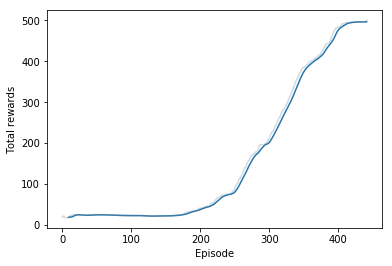

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

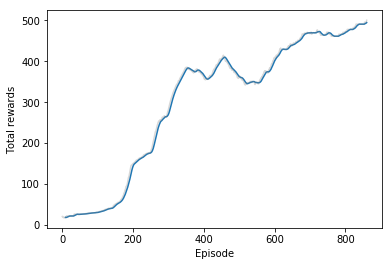

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

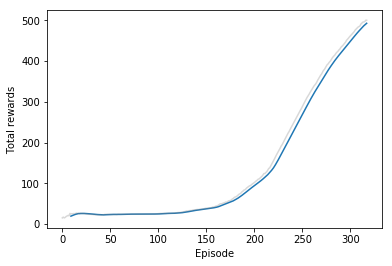

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

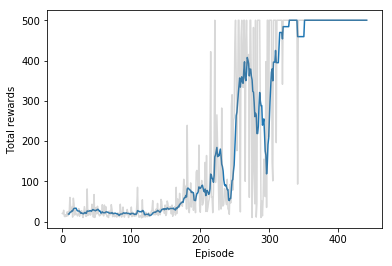

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

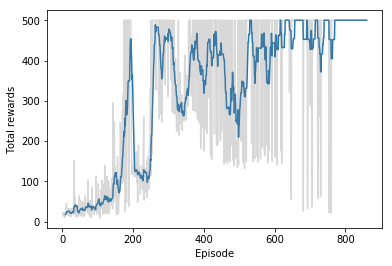

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

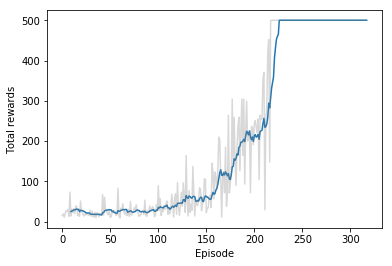

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

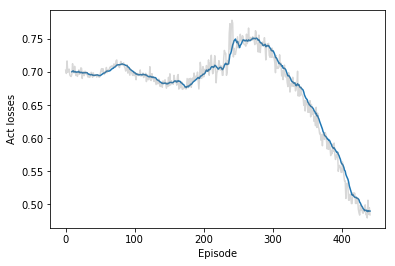

In [20]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

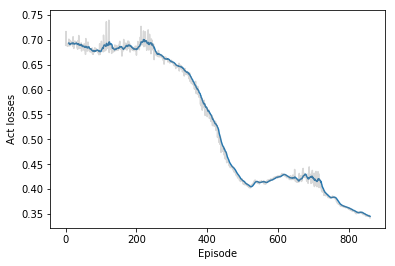

In [19]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

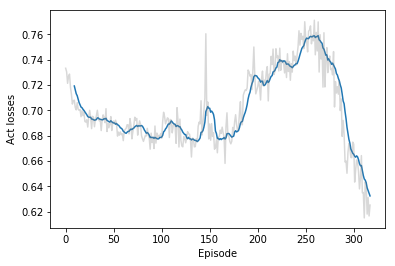

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

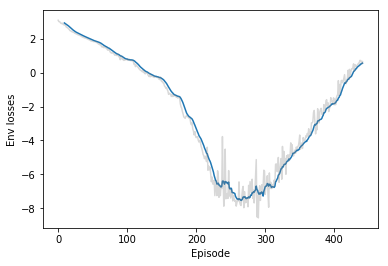

In [21]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

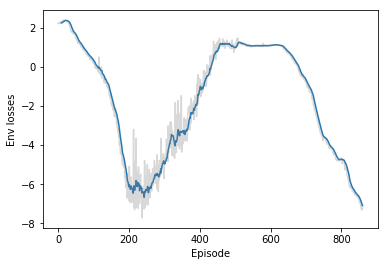

In [20]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

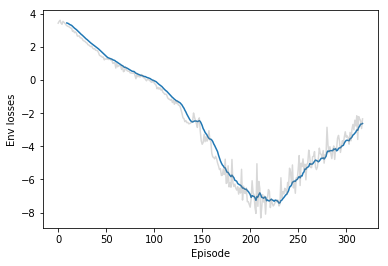

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

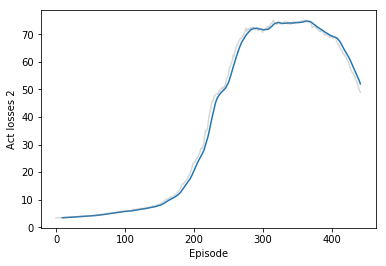

In [22]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

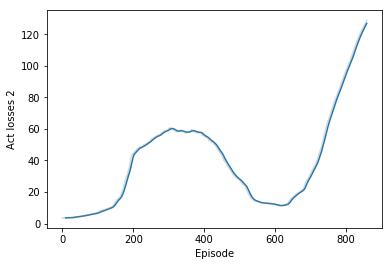

In [21]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

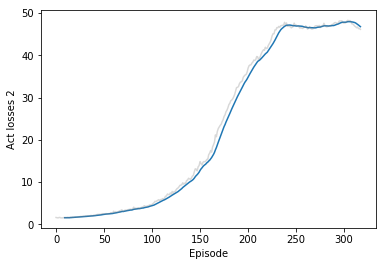

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
